In [1]:
using Bootstrap
using CSV
using CategoricalArrays
using Chain
using DataFrames
import Downloads
using GLM
using Plots
using Random
using StatsPlots
using Statistics

In [2]:
ENV["LINES"] = 20
ENV["COLUMNS"] = 1000

1000

In [3]:
Downloads.download("https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Participation.csv", "participation.csv")

"participation.csv"

In [4]:
df_raw = CSV.read("participation.csv", DataFrame)

872×8 DataFrame
 Row │ Column1  lfp     lnnlinc  age      educ   nyc    noc    foreign 
     │ Int64    String  Float64  Float64  Int64  Int64  Int64  String  
─────┼─────────────────────────────────────────────────────────────────
   1 │       1  no      10.7875      3.0      8      1      1  no
   2 │       2  yes     10.5243      4.5      8      0      1  no
   3 │       3  no      10.9686      4.6      9      0      0  no
   4 │       4  no      11.105       3.1     11      2      0  no
   5 │       5  no      11.1085      4.4     12      0      2  no
   6 │       6  yes     11.0283      4.2     12      0      1  no
  ⋮  │    ⋮       ⋮        ⋮        ⋮       ⋮      ⋮      ⋮       ⋮
 868 │     868  no      10.5974      2.4      4      2      1  yes
 869 │     869  yes     10.3778      4.8      8      0      0  yes
 870 │     870  no      10.1337      2.4      6      2      0  yes
 871 │     871  yes     10.9324      4.1     10      0      1  yes
 872 │     872  no      11.2207      5.1     10      0      0  yes
                                                       861 rows omitted

In [5]:
df = select(df_raw,
            :lfp => (x -> recode(x, "yes" => 1, "no" => 0)) => :lfp,
            :lnnlinc,
            :age,
            :age => ByRow(x -> x^2) => :age²,
            Between(:educ, :noc),
            :foreign => categorical => :foreign)

872×8 DataFrame
 Row │ lfp    lnnlinc  age      age²     educ   nyc    noc    foreign 
     │ Int64  Float64  Float64  Float64  Int64  Int64  Int64  Cat…    
─────┼────────────────────────────────────────────────────────────────
   1 │     0  10.7875      3.0     9.0       8      1      1  no
   2 │     1  10.5243      4.5    20.25      8      0      1  no
   3 │     0  10.9686      4.6    21.16      9      0      0  no
   4 │     0  11.105       3.1     9.61     11      2      0  no
   5 │     0  11.1085      4.4    19.36     12      0      2  no
   6 │     1  11.0283      4.2    17.64     12      0      1  no
  ⋮  │   ⋮       ⋮        ⋮        ⋮       ⋮      ⋮      ⋮       ⋮
 868 │     0  10.5974      2.4     5.76      4      2      1  yes
 869 │     1  10.3778      4.8    23.04      8      0      0  yes
 870 │     0  10.1337      2.4     5.76      6      2      0  yes
 871 │     1  10.9324      4.1    16.81     10      0      1  yes
 872 │     0  11.2207      5.1    26.01     10      0      0  yes
                                                      861 rows omitted

In [6]:
@chain df begin
    groupby(:lfp)
    combine([:lnnlinc, :age, :educ, :nyc, :noc] .=> mean)
end

2×6 DataFrame
 Row │ lfp    lnnlinc_mean  age_mean  educ_mean  nyc_mean  noc_mean 
     │ Int64  Float64       Float64   Float64    Float64   Float64  
─────┼──────────────────────────────────────────────────────────────
   1 │     0       10.7513   4.08535    9.59448  0.409766  0.902335
   2 │     1       10.6083   3.89002    8.97007  0.197007  1.07731

In [7]:
@chain df begin
    groupby([:lfp, :foreign])
    combine(nrow)
    unstack(:lfp, :foreign, :nrow)
    select(:lfp, [:no, :yes] => ByRow((x, y) -> y / (x + y)) => :foreign_yes)
end

2×2 DataFrame
 Row │ lfp    foreign_yes 
     │ Int64  Float64     
─────┼────────────────────
   1 │     0     0.146497
   2 │     1     0.366584

In [8]:
gd = groupby(df, :lfp)

GroupedDataFrame with 2 groups based on key: lfp
First Group (471 rows): lfp = 0
 Row │ lfp    lnnlinc  age      age²     educ   nyc    noc    foreign 
     │ Int64  Float64  Float64  Float64  Int64  Int64  Int64  Cat…    
─────┼────────────────────────────────────────────────────────────────
   1 │     0  10.7875      3.0     9.0       8      1      1  no
   2 │     0  10.9686      4.6    21.16      9      0      0  no
   3 │     0  11.105       3.1     9.61     11      2      0  no
   4 │     0  11.1085      4.4    19.36     12      0      2  no
   5 │     0  11.4547      5.1    26.01      8      0      0  no
   6 │     0  10.6247      3.9    15.21     12      0      0  no
  ⋮  │   ⋮       ⋮        ⋮        ⋮       ⋮      ⋮      ⋮       ⋮
 466 │     0  11.111       3.5    12.25     10      1      1  yes
 467 │     0  10.4714      5.1    26.01      9      0      1  yes
 468 │     0  10.1475      4.1    16.81      5      1      0  yes
 469 │     0  10.5974      2.4     5.76      4      2      1  yes
 470 │     0  10.1337      2.4     5.76      6      2      0  yes
 471 │     0  11.2207      5.1    26.01     10      0      0  yes
                                                      459 rows omitted
⋮
Last Group (401 rows): lfp = 1
 Row │ lfp    lnnlinc  age      age²     educ   nyc    noc    foreign 
     │ Int64  Float64  Float64  Float64  Int64  Int64  Int64  Cat…    
─────┼────────────────────────────────────────────────────────────────
   1 │     1  10.5243      4.5    20.25      8      0      1  no
   2 │     1  11.0283      4.2    17.64     12      0      1  no
   3 │     1  10.4909      3.2    10.24      8      0      2  no
   4 │     1  11.844       3.9    15.21     12      0      0  no
   5 │     1  10.9578      5.3    28.09     11      0      0  no
   6 │     1  11.1081      4.6    21.16     11      0      1  no
  ⋮  │   ⋮       ⋮        ⋮        ⋮       ⋮      ⋮      ⋮       ⋮
 396 │     1  10.5289      3.4    11.56      9      1      1  yes
 397 │     1  10.4685      3.3    10.89      6      0      2  yes
 398 │     1  10.6932      3.5    12.25      9      0      2  yes
 399 │     1  10.0276      4.2    17.64     14      0      0  yes
 400 │     1  10.3778      4.8    23.04      8      0      0  yes
 401 │     1  10.9324      4.1    16.81     10      0      1  yes
                                                      389 rows omitted

In [9]:
gd[2]

401×8 SubDataFrame
 Row │ lfp    lnnlinc  age      age²     educ   nyc    noc    foreign 
     │ Int64  Float64  Float64  Float64  Int64  Int64  Int64  Cat…    
─────┼────────────────────────────────────────────────────────────────
   1 │     1  10.5243      4.5    20.25      8      0      1  no
   2 │     1  11.0283      4.2    17.64     12      0      1  no
   3 │     1  10.4909      3.2    10.24      8      0      2  no
   4 │     1  11.844       3.9    15.21     12      0      0  no
   5 │     1  10.9578      5.3    28.09     11      0      0  no
   6 │     1  11.1081      4.6    21.16     11      0      1  no
  ⋮  │   ⋮       ⋮        ⋮        ⋮       ⋮      ⋮      ⋮       ⋮
 397 │     1  10.4685      3.3    10.89      6      0      2  yes
 398 │     1  10.6932      3.5    12.25      9      0      2  yes
 399 │     1  10.0276      4.2    17.64     14      0      0  yes
 400 │     1  10.3778      4.8    23.04      8      0      0  yes
 401 │     1  10.9324      4.1    16.81     10      0      1  yes
                                                      390 rows omitted

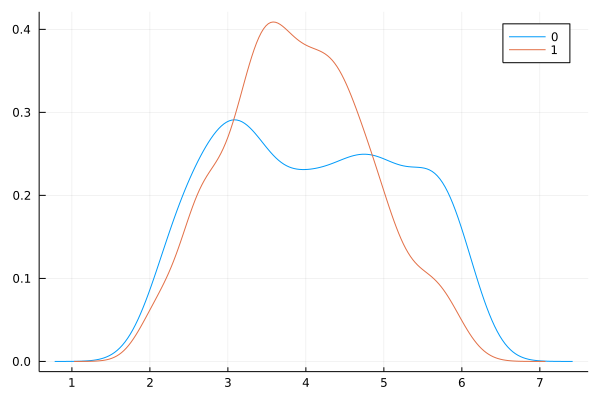

In [10]:
@df df density(:age, group=:lfp)

In [11]:
probit = glm(@formula(lfp ~ lnnlinc + age + age² + educ + nyc + noc + foreign),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + age² + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age²          -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc           -0.146985  

In [12]:
probit = glm(Term(:lfp) ~ sum(Term.(propertynames(df)[2:end])),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + age² + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age²          -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc           -0.146985  

In [13]:
Term(:lfp) ~ sum(Term.(propertynames(df)[2:end]))

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  age²(unknown)
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

In [14]:
@formula(lfp ~ lnnlinc + age + age² + educ + nyc + noc + foreign)

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  age²(unknown)
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

In [15]:
probit = glm(@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + :(age ^ 2) + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age ^ 2       -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc           -0.14

In [16]:
@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign)

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  (age)->age ^ 2
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

In [17]:
df_pred = DataFrame(lnnlinc=10.0, age= 2.0:0.01:6.2, educ = 9, nyc = 0, noc = 1, foreign = "yes")

421×6 DataFrame
 Row │ lnnlinc  age      educ   nyc    noc    foreign 
     │ Float64  Float64  Int64  Int64  Int64  String  
─────┼────────────────────────────────────────────────
   1 │    10.0     2.0       9      0      1  yes
   2 │    10.0     2.01      9      0      1  yes
   3 │    10.0     2.02      9      0      1  yes
   4 │    10.0     2.03      9      0      1  yes
   5 │    10.0     2.04      9      0      1  yes
   6 │    10.0     2.05      9      0      1  yes
  ⋮  │    ⋮        ⋮       ⋮      ⋮      ⋮       ⋮
 417 │    10.0     6.16      9      0      1  yes
 418 │    10.0     6.17      9      0      1  yes
 419 │    10.0     6.18      9      0      1  yes
 420 │    10.0     6.19      9      0      1  yes
 421 │    10.0     6.2       9      0      1  yes
                                      410 rows omitted

In [18]:
probit_pred = predict(probit, df_pred, interval=:confidence)

421×3 DataFrame
 Row │ prediction  lower     upper    
     │ Float64?    Float64?  Float64? 
─────┼────────────────────────────────
   1 │   0.786122  0.636712  0.891844
   2 │   0.78872   0.641194  0.892941
   3 │   0.791282  0.645623  0.894026
   4 │   0.79381   0.650001  0.895097
   5 │   0.796302  0.654325  0.896155
   6 │   0.79876   0.658597  0.8972
  ⋮  │     ⋮          ⋮         ⋮
 417 │   0.285902  0.148645  0.464727
 418 │   0.280642  0.144299  0.459905
 419 │   0.275409  0.14002   0.455078
 420 │   0.270205  0.13581   0.450245
 421 │   0.265032  0.131668  0.445407
                      410 rows omitted

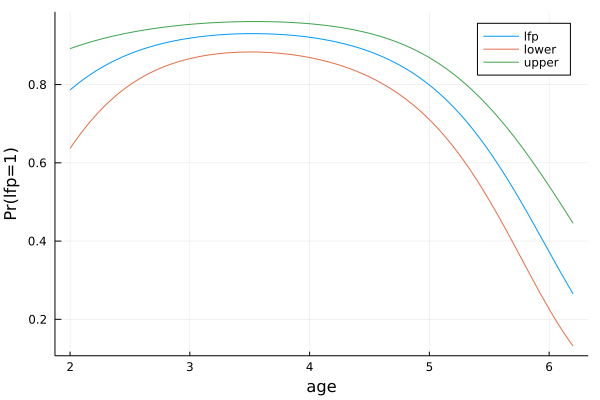

In [23]:
plot(df_pred.age, Matrix(probit_pred), labels=["lfp" "lower" "upper"],
     xlabel="age", ylabel="Pr(lfp=1)")

In [19]:
probit

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + :(age ^ 2) + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age ^ 2       -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc           -0.14

In [20]:
function boot_sample(df)
    df_boot = df[rand(1:nrow(df), nrow(df)), :]
    probit_boot = glm(@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign),
                      df_boot, Binomial(), ProbitLink())
    return (; (Symbol.(coefnames(probit_boot)) .=> coef(probit_boot))...)
end

boot_sample (generic function with 1 method)

In [21]:
function run_boot(df, reps)
    coef_boot = DataFrame()
    for _ in 1:reps
        push!(coef_boot, boot_sample(df))
    end
    return coef_boot
end

run_boot (generic function with 1 method)

In [22]:
Random.seed!(1234)
@time coef_boot = run_boot(df, 1000)

  4.493619 seconds (6.58 M allocations: 964.761 MiB, 4.83% gc time)


1000×8 DataFrame
  Row │ (Intercept)  lnnlinc    age      age ^ 2    educ          nyc        noc         foreign: yes 
      │ Float64      Float64    Float64  Float64    Float64       Float64    Float64     Float64      
──────┼───────────────────────────────────────────────────────────────────────────────────────────────
    1 │     3.27668  -0.685018  2.43103  -0.346242   0.0358374    -0.656125  -0.204708       0.897463
    2 │     3.46174  -0.604296  1.80522  -0.271183   0.0344276    -0.830026  -0.112685       0.849524
    3 │     5.58553  -0.931202  2.56893  -0.351696   0.0088754    -0.661503  -0.132513       0.751413
    4 │     5.36834  -0.869949  2.47276  -0.348879   0.0102268    -0.680439  -0.117942       0.460296
    5 │     5.02884  -0.815314  2.23525  -0.309316   0.0122217    -0.679034  -0.156954       0.627065
    6 │     3.18287  -0.66076   2.31433  -0.321379   0.019614     -0.716859  -0.178211       0.786647
  ⋮   │      ⋮           ⋮         ⋮         ⋮           ⋮            ⋮          ⋮            ⋮
  996 │     5.06295  -0.655272  1.43125  -0.22376    0.0113027    -0.729004  -0.0795616      0.617595
  997 │     5.75984  -0.80169   1.47785  -0.213519   0.0511737    -0.646884  -0.0868693      0.813631
  998 │     1.79979  -0.475717  1.93894  -0.27116    0.0164045    -0.764962  -0.124737       0.753752
  999 │     3.446    -0.654806  2.24378  -0.316282   0.0208654    -0.728688  -0.228742       0.465682
 1000 │     2.08841  -0.524569  2.39508  -0.329378  -0.0262097    -0.655382  -0.159616       0.386226
                                                                                      989 rows omitted

In [23]:
conf_boot = mapcols(x -> quantile(x, [0.025, 0.975]), coef_boot)

2×8 DataFrame
 Row │ (Intercept)  lnnlinc    age      age ^ 2    educ        nyc        noc         foreign: yes 
     │ Float64      Float64    Float64  Float64    Float64     Float64    Float64     Float64      
─────┼─────────────────────────────────────────────────────────────────────────────────────────────
   1 │     1.06625  -0.94311   1.24434  -0.397132  -0.0154263  -0.937041  -0.251984       0.469018
   2 │     6.59637  -0.424606  2.91247  -0.191457   0.0543084  -0.525028  -0.0503898      0.972134

In [24]:
confint(probit)

8×2 Matrix{Float64}:
  0.992006   6.50591
 -0.92549   -0.408374
  1.28073    2.86989
 -0.392235  -0.196456
 -0.015937   0.0543295
 -0.911238  -0.517691
 -0.246718  -0.0472509
  0.476589   0.95217

In [25]:
conf_param = DataFrame(permutedims(confint(probit)), names(conf_boot))

2×8 DataFrame
 Row │ (Intercept)  lnnlinc    age      age ^ 2    educ        nyc        noc         foreign: yes 
     │ Float64      Float64    Float64  Float64    Float64     Float64    Float64     Float64      
─────┼─────────────────────────────────────────────────────────────────────────────────────────────
   1 │    0.992006  -0.92549   1.28073  -0.392235  -0.015937   -0.911238  -0.246718       0.476589
   2 │    6.50591   -0.408374  2.86989  -0.196456   0.0543295  -0.517691  -0.0472509      0.95217

In [26]:
append!(conf_boot, conf_param)

4×8 DataFrame
 Row │ (Intercept)  lnnlinc    age      age ^ 2    educ        nyc        noc         foreign: yes 
     │ Float64      Float64    Float64  Float64    Float64     Float64    Float64     Float64      
─────┼─────────────────────────────────────────────────────────────────────────────────────────────
   1 │    1.06625   -0.94311   1.24434  -0.397132  -0.0154263  -0.937041  -0.251984       0.469018
   2 │    6.59637   -0.424606  2.91247  -0.191457   0.0543084  -0.525028  -0.0503898      0.972134
   3 │    0.992006  -0.92549   1.28073  -0.392235  -0.015937   -0.911238  -0.246718       0.476589
   4 │    6.50591   -0.408374  2.86989  -0.196456   0.0543295  -0.517691  -0.0472509      0.95217

In [27]:
insertcols!(conf_boot, 1, :statistic => ["boot lo", "boot hi", "parametric lo", "parametric hi"])

4×9 DataFrame
 Row │ statistic      (Intercept)  lnnlinc    age      age ^ 2    educ        nyc        noc         foreign: yes 
     │ String         Float64      Float64    Float64  Float64    Float64     Float64    Float64     Float64      
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ boot lo           1.06625   -0.94311   1.24434  -0.397132  -0.0154263  -0.937041  -0.251984       0.469018
   2 │ boot hi           6.59637   -0.424606  2.91247  -0.191457   0.0543084  -0.525028  -0.0503898      0.972134
   3 │ parametric lo     0.992006  -0.92549   1.28073  -0.392235  -0.015937   -0.911238  -0.246718       0.476589
   4 │ parametric hi     6.50591   -0.408374  2.86989  -0.196456   0.0543295  -0.517691  -0.0472509      0.95217

In [28]:
conf_boot_t = permutedims(conf_boot, :statistic)

8×5 DataFrame
 Row │ statistic     boot lo     boot hi     parametric lo  parametric hi 
     │ String        Float64     Float64     Float64        Float64       
─────┼────────────────────────────────────────────────────────────────────
   1 │ (Intercept)    1.06625     6.59637         0.992006      6.50591
   2 │ lnnlinc       -0.94311    -0.424606       -0.92549      -0.408374
   3 │ age            1.24434     2.91247         1.28073       2.86989
   4 │ age ^ 2       -0.397132   -0.191457       -0.392235     -0.196456
   5 │ educ          -0.0154263   0.0543084      -0.015937      0.0543295
   6 │ nyc           -0.937041   -0.525028       -0.911238     -0.517691
   7 │ noc           -0.251984   -0.0503898      -0.246718     -0.0472509
   8 │ foreign: yes   0.469018    0.972134        0.476589      0.95217

In [29]:
insertcols!(conf_boot_t, 2, :estimate => coef(probit))

8×6 DataFrame
 Row │ statistic     estimate    boot lo     boot hi     parametric lo  parametric hi 
     │ String        Float64     Float64     Float64     Float64        Float64       
─────┼────────────────────────────────────────────────────────────────────────────────
   1 │ (Intercept)    3.74896     1.06625     6.59637         0.992006      6.50591
   2 │ lnnlinc       -0.666932   -0.94311    -0.424606       -0.92549      -0.408374
   3 │ age            2.07531     1.24434     2.91247         1.28073       2.86989
   4 │ age ^ 2       -0.294345   -0.397132   -0.191457       -0.392235     -0.196456
   5 │ educ           0.0191963  -0.0154263   0.0543084      -0.015937      0.0543295
   6 │ nyc           -0.714465   -0.937041   -0.525028       -0.911238     -0.517691
   7 │ noc           -0.146985   -0.251984   -0.0503898      -0.246718     -0.0472509
   8 │ foreign: yes   0.71438     0.469018    0.972134        0.476589      0.95217

In [30]:
select!(conf_boot_t, :statistic, :estimate, 3:6 .=> x -> abs.(x .- conf_boot_t.estimate), renamecols=false)

8×6 DataFrame
 Row │ statistic     estimate    boot lo    boot hi    parametric lo  parametric hi 
     │ String        Float64     Float64    Float64    Float64        Float64       
─────┼──────────────────────────────────────────────────────────────────────────────
   1 │ (Intercept)    3.74896    2.68271    2.84741        2.75695        2.75695
   2 │ lnnlinc       -0.666932   0.276178   0.242326       0.258558       0.258558
   3 │ age            2.07531    0.830966   0.837163       0.794584       0.794584
   4 │ age ^ 2       -0.294345   0.102787   0.102889       0.0978895      0.0978895
   5 │ educ           0.0191963  0.0346226  0.0351121      0.0351333      0.0351333
   6 │ nyc           -0.714465   0.222576   0.189437       0.196774       0.196774
   7 │ noc           -0.146985   0.104999   0.0965947      0.0997336      0.0997336
   8 │ foreign: yes   0.71438    0.245362   0.257754       0.23779        0.23779

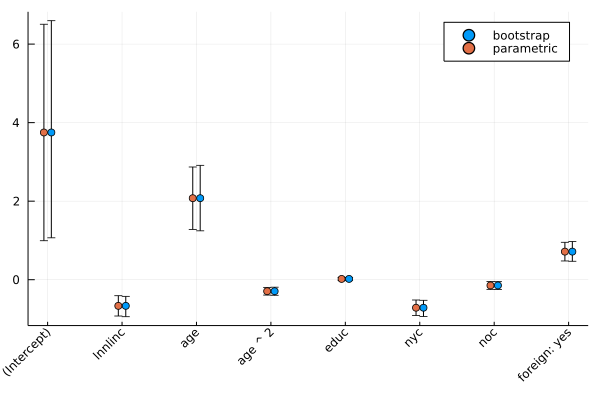

In [31]:
scatter(0.05 .+ (1:8), conf_boot_t.estimate,
        yerror=(conf_boot_t."boot lo", conf_boot_t."boot hi"),
        label="bootstrap",
        xticks=(1:8, conf_boot_t.statistic), xrotation=45)
scatter!(-0.05 .+ (1:8), conf_boot_t.estimate,
         yerror=(conf_boot_t."parametric lo", conf_boot_t."parametric hi"),
         label="parametric")

In [32]:
function boot_probit(df_boot)
    probit_boot = glm(@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign),
                      df_boot, Binomial(), ProbitLink())
    return (; (Symbol.(coefnames(probit_boot)) .=> coef(probit_boot))...)
end

boot_probit (generic function with 1 method)

In [33]:
Random.seed!(1234)
@time bs = bootstrap(boot_probit, df, BasicSampling(1000))

  3.168446 seconds (3.85 M allocations: 785.173 MiB, 4.40% gc time, 67.74% compilation time)


Bootstrap Sampling
  Estimates:
     Var │ Estimate    Bias          StdError
         │ Float64     Float64       Float64
    ─────┼─────────────────────────────────────
       1 │  3.74896     0.0479617    1.36775
       2 │ -0.666932   -0.0106807    0.130741
       3 │  2.07531     0.0370709    0.422754
       4 │ -0.294345   -0.00502473   0.0521531
       5 │  0.0191963   0.000703102  0.0181475
       6 │ -0.714465   -0.0106769    0.108667
       7 │ -0.146985   -0.00404358   0.051472
       8 │  0.71438     0.0094247    0.123851
  Sampling: BasicSampling
  Samples:  1000
  Data:     DataFrame: { 872 × 8 }


In [34]:
bs_ci = confint(bs, PercentileConfInt(0.95))

((3.7489556492271108, 1.066245983435171, 6.596366029686565), (-0.6669318467301562, -0.9431096226752889, -0.42460580882388094), (2.075310025309943, 1.2443435825374765, 2.9124734945385455), (-0.2943452031363773, -0.3971318919150751, -0.19145657341949654), (0.01919626008510499, -0.01542631836583384, 0.05430837906449797), (-0.7144647481686731, -0.9370411722162185, -0.5250276743069752), (-0.1469845045078344, -0.25198378115277537, -0.05038976115323891), (0.7143798526957524, 0.4690178809315581, 0.972134322270289))

In [35]:
conf_boot_t.bootstrap = [(ci[1], ci[1] - ci[2], ci[3] - ci[1]) for ci in bs_ci]

8-element Vector{Tuple{Float64, Float64, Float64}}:
 (3.7489556492271108, 2.68270966579194, 2.847410380459454)
 (-0.6669318467301562, 0.2761777759451327, 0.24232603790627522)
 (2.075310025309943, 0.8309664427724666, 0.8371634692286025)
 (-0.2943452031363773, 0.10278668877869779, 0.10288862971688076)
 (0.01919626008510499, 0.03462257845093883, 0.03511211897939298)
 (-0.7144647481686731, 0.2225764240475454, 0.18943707386169795)
 (-0.1469845045078344, 0.10499927664494096, 0.09659474335459549)
 (0.7143798526957524, 0.24536197176419433, 0.2577544695745365)

In [36]:
conf_boot_t

8×7 DataFrame
 Row │ statistic     estimate    boot lo    boot hi    parametric lo  parametric hi  bootstrap                         
     │ String        Float64     Float64    Float64    Float64        Float64        Tuple…                            
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ (Intercept)    3.74896    2.68271    2.84741        2.75695        2.75695    (3.74896, 2.68271, 2.84741)
   2 │ lnnlinc       -0.666932   0.276178   0.242326       0.258558       0.258558   (-0.666932, 0.276178, 0.242326)
   3 │ age            2.07531    0.830966   0.837163       0.794584       0.794584   (2.07531, 0.830966, 0.837163)
   4 │ age ^ 2       -0.294345   0.102787   0.102889       0.0978895      0.0978895  (-0.294345, 0.102787, 0.102889)
   5 │ educ           0.0191963  0.0346226  0.0351121      0.0351333      0.0351333  (0.0191963, 0.0346226, 0.0351121)
   6 │ nyc           -0.714465   0.222576   0.189437       0.196774       0.196774   (-0.714465, 0.222576, 0.189437)
   7 │ noc           -0.146985   0.104999   0.0965947      0.0997336      0.0997336  (-0.146985, 0.104999, 0.0965947)
   8 │ foreign: yes   0.71438    0.245362   0.257754       0.23779        0.23779    (0.71438, 0.245362, 0.257754)

In [37]:
select!(conf_boot_t, Not(:bootstrap), :bootstrap => ["estimate 2", "boot lo 2", "boot hi 2"])

8×9 DataFrame
 Row │ statistic     estimate    boot lo    boot hi    parametric lo  parametric hi  estimate 2  boot lo 2  boot hi 2 
     │ String        Float64     Float64    Float64    Float64        Float64        Float64     Float64    Float64   
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ (Intercept)    3.74896    2.68271    2.84741        2.75695        2.75695     3.74896    2.68271    2.84741
   2 │ lnnlinc       -0.666932   0.276178   0.242326       0.258558       0.258558   -0.666932   0.276178   0.242326
   3 │ age            2.07531    0.830966   0.837163       0.794584       0.794584    2.07531    0.830966   0.837163
   4 │ age ^ 2       -0.294345   0.102787   0.102889       0.0978895      0.0978895  -0.294345   0.102787   0.102889
   5 │ educ           0.0191963  0.0346226  0.0351121      0.0351333      0.0351333   0.0191963  0.0346226  0.0351121
   6 │ nyc           -0.714465   0.222576   0.189437       0.196774       0.196774   -0.714465   0.222576   0.189437
   7 │ noc           -0.146985   0.104999   0.0965947      0.0997336      0.0997336  -0.146985   0.104999   0.0965947
   8 │ foreign: yes   0.71438    0.245362   0.257754       0.23779        0.23779     0.71438    0.245362   0.257754

In [38]:
select(conf_boot_t, :statistic, r"estimate", r"lo", r"hi")

8×9 DataFrame
 Row │ statistic     estimate    estimate 2  boot lo    parametric lo  boot lo 2  boot hi    parametric hi  boot hi 2 
     │ String        Float64     Float64     Float64    Float64        Float64    Float64    Float64        Float64   
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ (Intercept)    3.74896     3.74896    2.68271        2.75695    2.68271    2.84741        2.75695    2.84741
   2 │ lnnlinc       -0.666932   -0.666932   0.276178       0.258558   0.276178   0.242326       0.258558   0.242326
   3 │ age            2.07531     2.07531    0.830966       0.794584   0.830966   0.837163       0.794584   0.837163
   4 │ age ^ 2       -0.294345   -0.294345   0.102787       0.0978895  0.102787   0.102889       0.0978895  0.102889
   5 │ educ           0.0191963   0.0191963  0.0346226      0.0351333  0.0346226  0.0351121      0.0351333  0.0351121
   6 │ nyc           -0.714465   -0.714465   0.222576       0.196774   0.222576   0.189437       0.196774   0.189437
   7 │ noc           -0.146985   -0.146985   0.104999       0.0997336  0.104999   0.0965947      0.0997336  0.0965947
   8 │ foreign: yes   0.71438     0.71438    0.245362       0.23779    0.245362   0.257754       0.23779    0.257754

In [39]:
sort(conf_boot_t, :estimate)

8×9 DataFrame
 Row │ statistic     estimate    boot lo    boot hi    parametric lo  parametric hi  estimate 2  boot lo 2  boot hi 2 
     │ String        Float64     Float64    Float64    Float64        Float64        Float64     Float64    Float64   
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ nyc           -0.714465   0.222576   0.189437       0.196774       0.196774   -0.714465   0.222576   0.189437
   2 │ lnnlinc       -0.666932   0.276178   0.242326       0.258558       0.258558   -0.666932   0.276178   0.242326
   3 │ age ^ 2       -0.294345   0.102787   0.102889       0.0978895      0.0978895  -0.294345   0.102787   0.102889
   4 │ noc           -0.146985   0.104999   0.0965947      0.0997336      0.0997336  -0.146985   0.104999   0.0965947
   5 │ educ           0.0191963  0.0346226  0.0351121      0.0351333      0.0351333   0.0191963  0.0346226  0.0351121
   6 │ foreign: yes   0.71438    0.245362   0.257754       0.23779        0.23779     0.71438    0.245362   0.257754
   7 │ age            2.07531    0.830966   0.837163       0.794584       0.794584    2.07531    0.830966   0.837163
   8 │ (Intercept)    3.74896    2.68271    2.84741        2.75695        2.75695     3.74896    2.68271    2.84741

In [40]:
conf_boot_t[sortperm(conf_boot_t."boot hi" + conf_boot_t."boot lo"), :]

8×9 DataFrame
 Row │ statistic     estimate    boot lo    boot hi    parametric lo  parametric hi  estimate 2  boot lo 2  boot hi 2 
     │ String        Float64     Float64    Float64    Float64        Float64        Float64     Float64    Float64   
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ educ           0.0191963  0.0346226  0.0351121      0.0351333      0.0351333   0.0191963  0.0346226  0.0351121
   2 │ noc           -0.146985   0.104999   0.0965947      0.0997336      0.0997336  -0.146985   0.104999   0.0965947
   3 │ age ^ 2       -0.294345   0.102787   0.102889       0.0978895      0.0978895  -0.294345   0.102787   0.102889
   4 │ nyc           -0.714465   0.222576   0.189437       0.196774       0.196774   -0.714465   0.222576   0.189437
   5 │ foreign: yes   0.71438    0.245362   0.257754       0.23779        0.23779     0.71438    0.245362   0.257754
   6 │ lnnlinc       -0.666932   0.276178   0.242326       0.258558       0.258558   -0.666932   0.276178   0.242326
   7 │ age            2.07531    0.830966   0.837163       0.794584       0.794584    2.07531    0.830966   0.837163
   8 │ (Intercept)    3.74896    2.68271    2.84741        2.75695        2.75695     3.74896    2.68271    2.84741